# HubMap- Hacking the Kidney
#### Goal - Mapping the human body at function tissue unit level - detect glomeruli FTUs in kidney

#### Implementation of Kaggle Notebooks - Converting the images to TF-Records

Link 1 - https://www.kaggle.com/marcosnovaes/hubmap-read-data-and-build-tfrecords <br>
Link 2 - https://www.kaggle.com/wrrosa/hubmap-tf-with-tpu-efficientunet-512x512-tfrecs

###### Step 1 - Install useful libraries

In [1]:
import cv2
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shutil
import tensorflow as tf
import glob
import tifffile
import gc

###### You can't read the data as is, convert it into smaller 512x512 tiles and then convert them into TFRecords.
##### Step 2 - Read the csv file

In [2]:
basepath_input = r'C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\hubmap-kidney-segmentation-data'
basepath_output = r'C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Output'
train_df = pd.read_csv(basepath_input+"/train.csv")
train_df

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
2,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
3,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
4,b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...
5,b2dc8411c,56157731 21 56172571 45 56187411 51 56202252 5...
6,0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
7,e79de561c,7334642 14 7350821 41 7367001 67 7383180 82 73...
8,095bf7a1f,113277795 21 113315936 53 113354083 87 1133922...
9,54f2eec69,124967057 36 124997425 109 125027828 147 12505...


##### Step 3 - Read each .tiff file and see its shape

img id = C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\hubmap-kidney-segmentation-data/train\0486052bb.tiff, shape = (25784, 34937, 3)


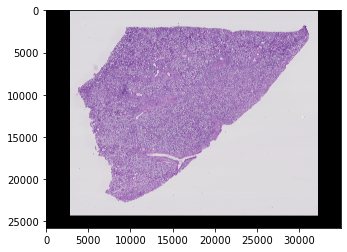

In [5]:
def verify_read(file_list):
    for file_name in file_list:
        baseimage = tifffile.imread(file_name)
        print('img id = {}, shape = {}'.format(file_name,baseimage.shape))
        plt.imshow(baseimage)
        gc.collect()
        break
        
file_list = glob.glob(basepath_input+'/train/*.tiff')
verify_read(file_list)

##### Step 4 - Read one image, visualize it, swap the axis if required.

In [14]:
working_image_index = 6
working_image_id = train_df['id'][working_image_index]
working_image_path = basepath_input+'/train/'+working_image_id+'.tiff'

In [15]:
baseimage = tifffile.imread(working_image_path)

In [16]:
print ('Original image shape', baseimage.shape)

Original image shape (25784, 34937, 3)


(25784, 34937, 3)


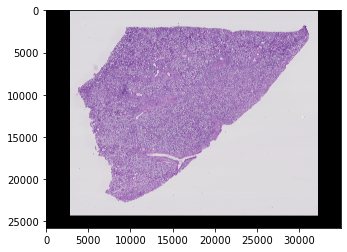

In [17]:
baseimage = np.squeeze(baseimage)
print (baseimage.shape)
if( baseimage.shape[0] == 3):
    baseimage = baseimage.swapaxes(0,1)
    baseimage = baseimage.swapaxes(1,2)
    print ('Swaped shape',baseimage.shape)

plt.figure()
plt.imshow(baseimage)

##### Step 5 - Read the json mask

In [40]:
working_image_id = '1e2425f28'
working_image_json_mask = basepath_input+'/test/'+working_image_id+'-anatomical-structure.json'
working_image_json_mask = basepath_input+'/train/'+working_image_id+'.json'
read_file = open(working_image_json_mask, "r") 
mask_data = json.load(read_file)
mask_data

[{'type': 'Feature',
  'id': 'PathAnnotationObject',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[13483, 19700],
     [13355, 19705],
     [13223, 19739],
     [13133.85, 19812.85],
     [13134, 19813],
     [13138, 19817],
     [13140, 19818],
     [13144, 19822],
     [13148, 19827],
     [13150, 19833],
     [13152, 19835],
     [13155, 19841],
     [13156, 19844],
     [13157, 19847],
     [13158, 19850],
     [13159, 19852],
     [13162, 19858],
     [13164, 19864],
     [13165, 19870],
     [13165, 19871],
     [13165, 19872],
     [13165, 19873],
     [13165, 19874],
     [13165, 19875],
     [13165, 19876],
     [13165, 19877],
     [13165, 19879],
     [13164, 19885],
     [13162, 19891],
     [13161, 19893],
     [13159, 19899],
     [13157.86, 19900.43],
     [13157, 19903],
     [13153, 19908],
     [13151, 19910],
     [13148, 19914],
     [13147, 19916],
     [13146.5, 19916.5],
     [13146, 19918],
     [13144.67, 19919.66],
     [13142, 19925],
     [13141, 19

In [38]:
def read_mask(mask_file, mask_shape):
    read_file = open(mask_file, "r", encoding='utf-8') 
    mask_data = json.load(read_file)
    print (mask_data)
    polys = []
    for index in range(mask_data.__len__()):
        geom = np.array(mask_data[index]['geometry']['coordinates'], dtype=np.int32)
        polys.append(geom)

    mask = np.zeros(mask_shape)
    print (type(polys), type(polys[0]), type(polys[0][0][0][0]))
    cv2.fillPoly(mask, polys, 1)
    mask = mask.astype(bool)
    return mask

[{'type': 'Feature', 'id': 'PathAnnotationObject', 'geometry': {'type': 'Polygon', 'coordinates': [[[23539, 353], [10067, 2465], [6519, 4238], [3044, 12538], [1921, 16002], [2015, 20402], [2951, 22087], [13062, 23491], [13438, 19325], [14620, 16876], [15296, 15862], [16521, 15905], [17830, 15778], [19308, 15313], [21462, 15736], [21504, 15736], [21504, 15778], [25221, 15862], [26783, 15102], [26530, 13413], [26615, 12526], [26699, 11850], [27018, 10279], [33287, 10449], [34989, 10364], [36662, 8861], [36918, 8208], [37258, 8634], [37258, 8662], [37145, 9485], [38279, 10733], [39926, 12769], [42713, 14036], [42755, 14036], [44360, 14501], [45796, 9686], [45796, 9644], [45627, 5674], [45627, 5632], [45627, 4956], [44402, 5421], [44360, 5421], [43135, 5548], [42544, 5421], [41615, 4703], [37603, 1451], [35787, 1029], [34604, 986], [34266, 3478], [31310, 1113], [23539, 353]]]}, 'properties': {'classification': {'name': 'Cortex', 'colorRGB': -1091353}, 'isLocked': False, 'measurements': []}

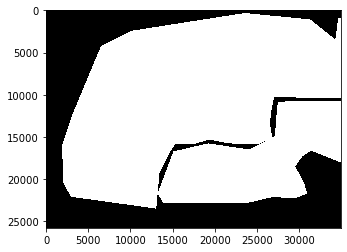

In [39]:
from PIL import Image
mask_shape = (baseimage.shape[0], baseimage.shape[1])
mask = read_mask(working_image_json_mask, mask_shape)
print (mask.shape)
img = Image.fromarray(mask)
plt.imshow(img, interpolation='nearest')

##### Step 6 - Tile the image into subparts of 512x512 

C:\Users\soodn\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


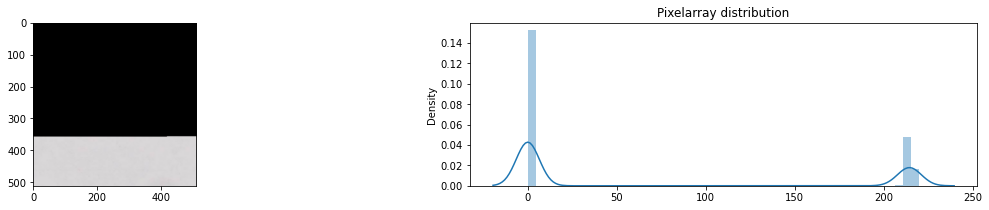

In [11]:
def show_tile_and_mask(baseimage, mask, tile_size, tile_col_pos, tile_row_pos):
    start_col = tile_col_pos*tile_size
    end_col = start_col + tile_size
    start_row = tile_row_pos * tile_size
    end_row = start_row + tile_size
    tile_image = baseimage[start_col:end_col, start_row:end_row,:]
    tile_mask = mask[start_col:end_col, start_row:end_row]
    fig, ax = plt.subplots(1,2,figsize=(20,3))
    ax[0].imshow(tile_image)
    ax[1].imshow(tile_mask)

def get_tile(baseimage, tile_size, tile_col_pos, tile_row_pos):
    start_col = tile_col_pos*tile_size
    end_col = start_col + tile_size
    start_row = tile_row_pos * tile_size
    end_row = start_row + tile_size
    tile_image = baseimage[start_col:end_col, start_row:end_row,:]
    return tile_image

def get_tile_mask(baseimage, tile_size, tile_col_pos, tile_row_pos):
    start_col = tile_col_pos*tile_size
    end_col = start_col + tile_size
    start_row = tile_row_pos * tile_size
    end_row = start_row + tile_size
    tile_image = baseimage[start_col:end_col, start_row:end_row]
    return tile_image

def show_tile_dist(tile):
    fig, ax = plt.subplots(1,2,figsize=(20,3))
    #ax[0].set_title("Tile ID = {} Xpos = {} Ypos = {}".format(img_mtd['tile_id'], img_mtd['tile_col_pos'],img_mtd['tile_row_pos']))
    ax[0].imshow(tile)
    ax[1].set_title("Pixelarray distribution");
    sns.distplot(tile.flatten(), ax=ax[1]);
    plt.savefig('mask.png')
    
tile_size = 512
tile = get_tile(baseimage, tile_size, 0, 0)
show_tile_dist(tile)

In [12]:
img_hist = np.histogram(tile)
print('histogram = {}'.format(img_hist[0]))
print('histogram_lowpass = {}'.format(np.sum(img_hist[0][0:4])))

histogram = [548070    206    471    769     90      0      0      0      3 236823]
histogram_lowpass = 549516


##### Since it is an edge tile, most of it is black, we will get a more even distribution when we move towards center of the image.

C:\Users\soodn\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


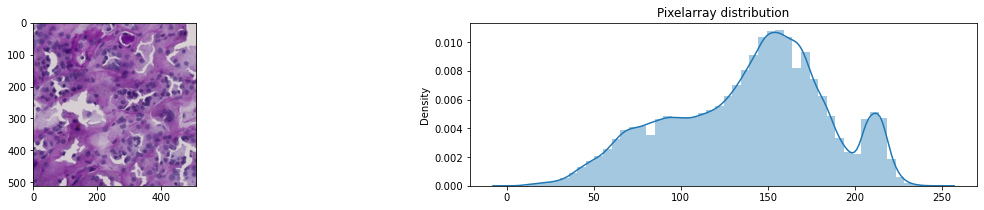

In [23]:
tile = get_tile(baseimage, tile_size, 26, 28)
show_tile_dist(tile)

In [14]:
img_hist = np.histogram(tile)
print('histogram = {}'.format(img_hist[0]))
print('histogram_lowpass = {}'.format(np.sum(img_hist[0][0:4])))

histogram = [ 10754  33774  64674  59615  84547 122013 107623 171018 128988   3426]
histogram_lowpass = 168817


##### Step 7 - Get the glomeruli coordinates from json file read before and see that specific tile

##### First glomeruli starts at (12002, 6553) coordinates. We expect to find it in (12002/512, 6553/512) tile, i.e., (23, 12).

C:\Users\soodn\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


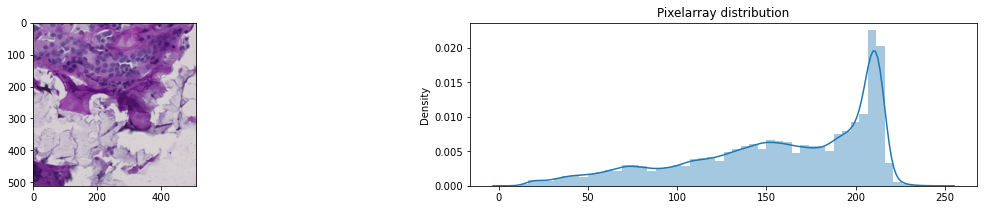

In [24]:
tile = get_tile(baseimage, tile_size, 27, 29)
show_tile_dist(tile)

In [16]:
img_hist = np.histogram(tile)
print('histogram = {}'.format(img_hist[0]))
print('histogram_lowpass = {}'.format(np.sum(img_hist[0][0:4])))

histogram = [  6952  19875  51086  96328 106648 158087 206671  85531  51705   3549]
histogram_lowpass = 174241


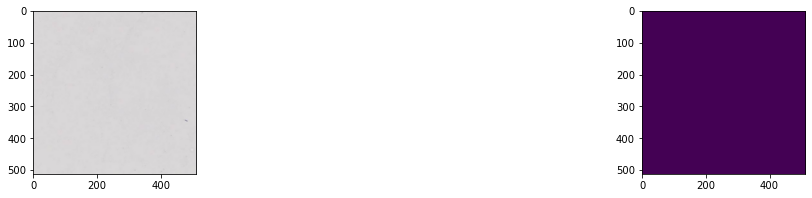

In [33]:
show_tile_and_mask(baseimage, mask, tile_size, 1, 1)

In [30]:
tile_mask = get_tile_mask(mask, tile_size, 60, 43)
mask_density = np.count_nonzero(tile_mask)
mask_density

0

##### We found our first glomeruli!

##### Step 8 - See a few more tiles

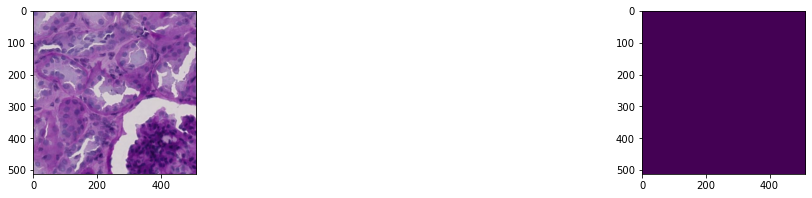

In [19]:
show_tile_and_mask(baseimage, mask, tile_size, 11, 23)

In [29]:
tile_mask = get_tile_mask(mask, tile_size, 60, 43)
mask_density = np.count_nonzero(tile_mask)
mask_density

0

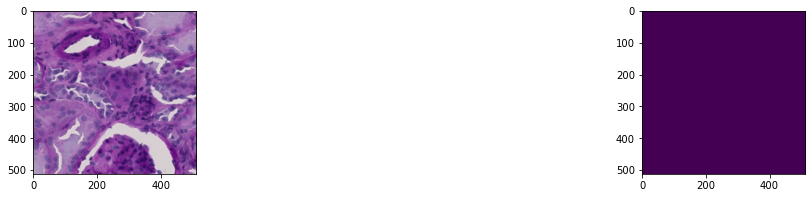

In [21]:
show_tile_and_mask(baseimage, mask, tile_size, 13, 24)

In [22]:
tile_mask = get_tile_mask(mask, tile_size, 14, 23)
mask_density = np.count_nonzero(tile_mask)
mask_density

0

##### Step 9 - Build TFRecords - Writing each tile to a TFRecord file, dataframe to store metadata including low pass energy, mask density.

In [56]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def image_example(image_index, image, mask, tile_id, tile_col_pos, tile_row_pos):
    image_shape = image.shape
    
    img_bytes = image.tostring()

    mask_bytes = mask.tostring()
    
    feature = {
        'img_index': _int64_feature(image_index),
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'num_channels': _int64_feature(image_shape[2]),
        'img_bytes': _bytes_feature(img_bytes),
        'mask' : _bytes_feature(mask_bytes),
        'tile_id':  _int64_feature(tile_id),
        'tile_col_pos': _int64_feature(tile_col_pos),
        'tile_row_pos': _int64_feature(tile_row_pos),
        
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def create_tfrecord( image_index, image, mask, tile_id, tile_col_pos, tile_row_pos, output_path):
    opts = tf.io.TFRecordOptions(compression_type="GZIP")
    with tf.io.TFRecordWriter(output_path, opts) as writer:
        tf_example = image_example(image_index, image, mask, tile_id, tile_col_pos, tile_row_pos)
        writer.write(tf_example.SerializeToString())
    writer.close()
    
def write_tfrecord_tiles( image_index, image_id, image, mask, tile_size, output_path ):
    output_dir = output_path+image_id
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)
    
    image_cols = image.shape[0]
    image_rows = image.shape[1]
    tile_cols = image_cols // tile_size
    tile_rows = image_rows // tile_size
    tileID = 0
    
    # create a pandas dataframe to store metadata for each tile
    tile_df = pd.DataFrame(columns = ['img_index', 'img_id','tile_id', 'tile_rel_path','tile_col_num', 'tile_row_num', 'lowband_density', 'mask_density'])
    
    # create one directory for each row of images
    for col_number in range(tile_cols):
        print('col_offset{} '.format(col_number),end='')
        dir_path = output_dir+'/col{}'.format(col_number)
        # create directory
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.mkdir(dir_path)
        for row_number in range(tile_rows):
            dataset_file_path = dir_path+'/col{}_row{}.tfrecords'.format(col_number,row_number)
            relative_path = image_id+'/col{}_row{}.tfrecords'.format(col_number,row_number)
            lower_col_range = col_number * tile_size
            higher_col_range = lower_col_range + tile_size
            lower_row_range = row_number * tile_size
            higher_row_range = lower_row_range + tile_size
            image_tile = image[lower_col_range:higher_col_range, lower_row_range:higher_row_range, :]
            tile_mask = mask[lower_col_range:higher_col_range, lower_row_range:higher_row_range]
            num_records = create_tfrecord( image_index, image_tile, tile_mask, tileID, col_number, row_number, dataset_file_path)
            # populate the metadata for this tile
            img_hist = np.histogram(image_tile)
            lowband_density = np.sum(img_hist[0][0:4])
            mask_density = np.count_nonzero(tile_mask)
            tile_df = tile_df.append({'img_index':image_index, 'img_id':image_id, 'tile_id': tileID, 'tile_rel_path':relative_path, 
                           'tile_col_num':col_number, 'tile_row_num':row_number,'lowband_density':lowband_density, 'mask_density':mask_density},ignore_index=True)
            tileID += 1
    return tile_df


In [57]:
output_dir = 'Output/output_train/'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)

tile_size = 512
num_images = train_df.shape[0]

for image_index in range(num_images):
    image_id = train_df['id'][image_index]
    image_path = basepath_input+'/train/'+image_id+'.tiff'
    image_json_mask =  basepath_input+'/train/'+image_id+'.json'
    print (image_path)
    baseimage = tifffile.imread(image_path)
    print ('original image shape',baseimage.shape)
    baseimage = np.squeeze(baseimage)
    if( baseimage.shape[0] == 3):
        baseimage = baseimage.swapaxes(0,1)
        baseimage = baseimage.swapaxes(1,2)
        print ('swaped shape',baseimage.shape)
    if (len(baseimage.shape) == 2):
        baseimage = baseimage.reshape(baseimage.shape[0], baseimage.shape[1], 1)
    mask_shape = (baseimage.shape[0], baseimage.shape[1])
    mask = read_mask(image_json_mask, mask_shape)

    print('writing tiles for image {}'.format(image_id))
    tile_df = write_tfrecord_tiles( image_index, image_id, baseimage, mask, tile_size, output_dir )

    #write the dataframe
    print('writing tile metadata for image {}'.format(image_id))
    df_path = output_dir+image_id+'_tiles.csv'
    tile_df.to_csv(df_path)
    gc.collect()

C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\hubmap-kidney-segmentation-data/train/2f6ecfcdf.tiff
original image shape (31278, 25794, 3)
<class 'list'> <class 'numpy.ndarray'> <class 'numpy.int32'>
writing tiles for image 2f6ecfcdf
col_offset0 

<ipython-input-56-371d01117989>:18: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img_bytes = image.tostring()
<ipython-input-56-371d01117989>:20: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mask_bytes = mask.tostring()


col_offset1 col_offset2 col_offset3 col_offset4 col_offset5 col_offset6 col_offset7 col_offset8 col_offset9 col_offset10 col_offset11 col_offset12 col_offset13 col_offset14 col_offset15 col_offset16 col_offset17 col_offset18 col_offset19 col_offset20 col_offset21 col_offset22 col_offset23 col_offset24 col_offset25 col_offset26 col_offset27 col_offset28 col_offset29 col_offset30 col_offset31 col_offset32 col_offset33 col_offset34 col_offset35 col_offset36 col_offset37 col_offset38 col_offset39 col_offset40 col_offset41 col_offset42 col_offset43 col_offset44 col_offset45 col_offset46 col_offset47 col_offset48 col_offset49 col_offset50 col_offset51 col_offset52 col_offset53 col_offset54 col_offset55 col_offset56 col_offset57 col_offset58 col_offset59 col_offset60 writing tile metadata for image 2f6ecfcdf
C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\hubmap-kidney-segmentation-data/train/8242609fa.tiff
original image shape (31299, 44066, 3)
<class 'list'> <class 'numpy.ndarray'> <cl

In [ ]:
#convert all the test images
img_file_list = glob.glob('test/*.tiff') 
mask_file_list = glob.glob('test/*.json')

print (img_file_list[0])
output_dir = output_dir = 'Output/output_test/'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)

tile_size = 512
num_images = img_file_list.__len__()
for image_index in range(num_images):
    file_name = img_file_list[image_index]
    print (file_name)
    prefix = file_name.split('.')
    parts = prefix[0].split("\\")
    image_id = parts[-1]
    image_path = img_file_list[image_index]
    image_json_mask = mask_file_list[image_index]

    baseimage = tifffile.imread(image_path)
    print ('original image shape',baseimage.shape)
    baseimage = np.squeeze(baseimage)
    if( baseimage.shape[0] == 3):
        baseimage = baseimage.swapaxes(0,1)
        baseimage = baseimage.swapaxes(1,2)
        print ('swaped shape',baseimage.shape)
    if (len(baseimage.shape) == 2):
        baseimage = baseimage.reshape(baseimage.shape[0], baseimage.shape[1], 1)
        
    # read json mask
    mask_shape = (baseimage.shape[0], baseimage.shape[1])
    mask = read_mask(image_json_mask, mask_shape)
    
    print('writing tiles for image {}'.format(image_id))
    tile_df = write_tfrecord_tiles( image_index, image_id, baseimage, mask, tile_size, output_dir )
    
    #write the dataframe
    print('writing tile metadata for image {}'.format(image_id))
    df_path = output_dir+image_id+'_tiles.csv'
    tile_df.to_csv(df_path)
    gc.collect()

##### Caveats - 
1. use 32-bit integers for cv2 functions. 
2. Use 'utf-8' encoding while reading json.
3. Making TFRecords takes a couple of hours.